2025-10-31 11:27:59.763375: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-31 11:27:59.875699: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-31 11:28:02.165598: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


🔍 COMPREHENSIVE DATASET ANALYSIS

1. Loading dataset...
Total images: 1995
Training samples: 1559
Validation samples: 279
Test samples: 157

2. CLASS DISTRIBUTION ANALYSIS
------------------------------

TRAINING SET:
  Total: 1559 samples
  Benign (Class 0): 528 samples (33.87%)
  Malignant (Class 1): 1031 samples (66.13%)
  Class ratio: 1.95:1
  ⚠️  Mild class imbalance detected

VALIDATION SET:
  Total: 279 samples
  Benign (Class 0): 84 samples (30.11%)
  Malignant (Class 1): 195 samples (69.89%)
  Class ratio: 2.32:1
  ⚠️  SIGNIFICANT CLASS IMBALANCE DETECTED!

TEST SET:
  Total: 157 samples
  Benign (Class 0): 13 samples (8.28%)
  Malignant (Class 1): 144 samples (91.72%)
  Class ratio: 11.08:1
  ⚠️  SIGNIFICANT CLASS IMBALANCE DETECTED!

3. PATIENT DISTRIBUTION ANALYSIS
------------------------------
Total unique patients: 82
Patients with only benign samples: 24
Patients with only malignant samples: 58
Patients with both benign & malignant: 0

4. IMAGE STATISTICS
--------------

2025-10-31 11:28:03.761640: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


  Batch shape: (32, 224, 224, 3)
  Data type: <dtype: 'float32'>
  Value range: 0.004 to 1.000
  Mean pixel value: 0.750
  Standard deviation: 0.127


2025-10-31 11:28:04.712038: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  Analyzed 160 images

Validation Image Analysis:
  Batch shape: (32, 224, 224, 3)
  Data type: <dtype: 'float32'>
  Value range: 0.008 to 1.000
  Mean pixel value: 0.730
  Standard deviation: 0.154


2025-10-31 11:28:05.831544: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  Analyzed 160 images

5. DATA AUGMENTATION VERIFICATION
------------------------------
Original batch - Min: 0.0 Max: 1.0
Augmented batch - Min: 0.08788037 Max: 1.1207781
✅ Data augmentation is working correctly

6. DATA VISUALIZATION
------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.4548368..1.0146776].


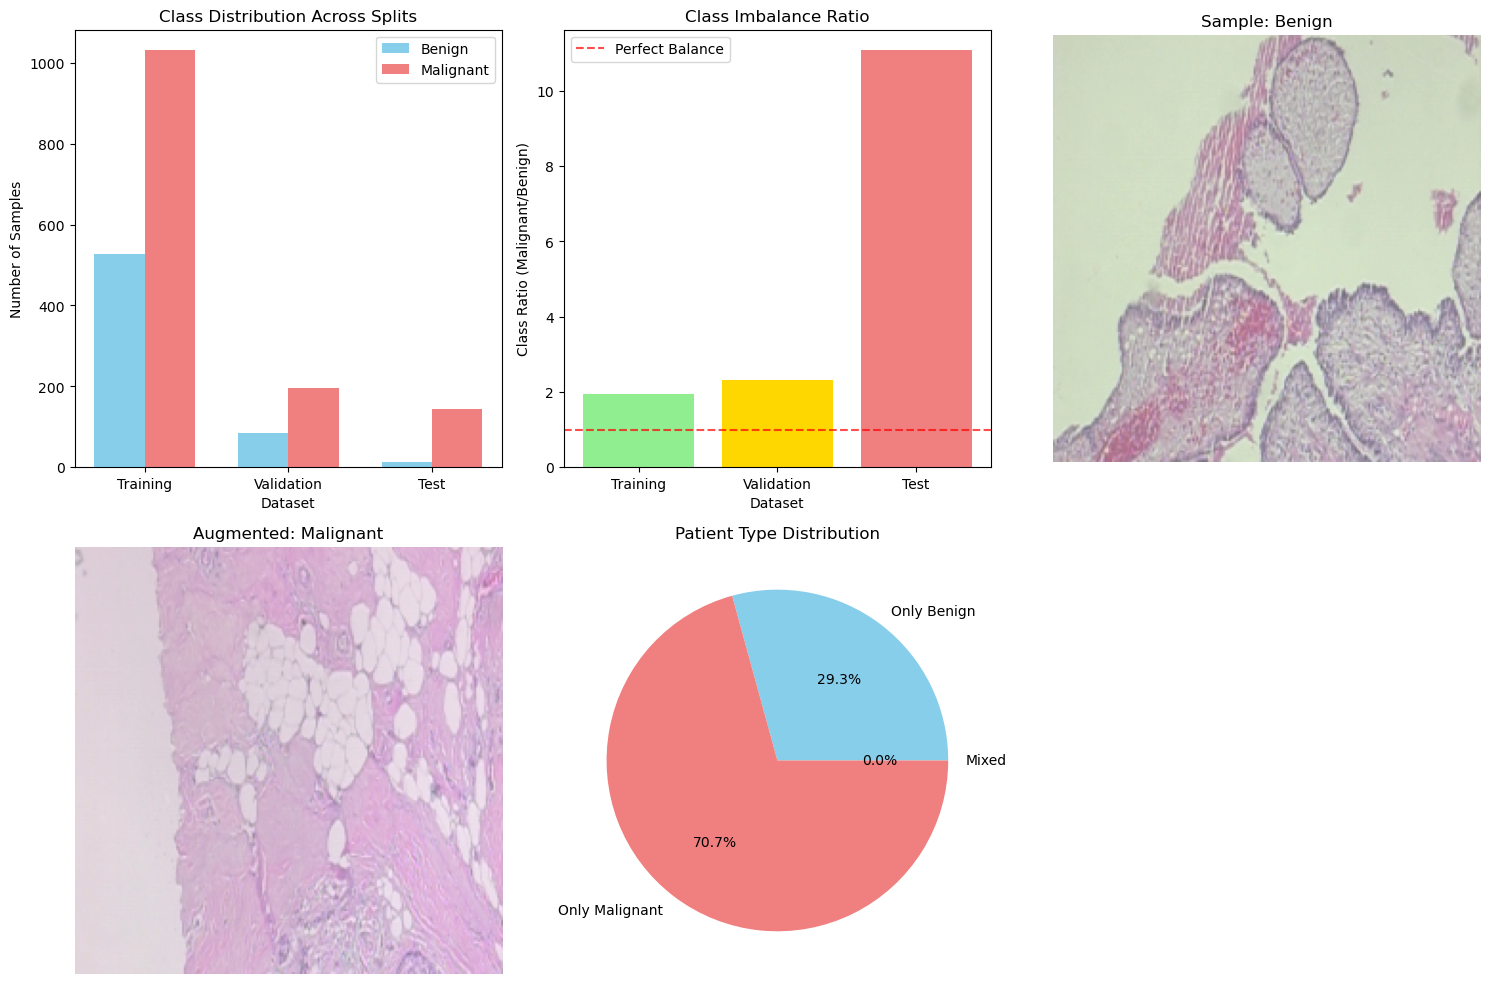


7. RECOMMENDATIONS
------------------------------
⚠️  STRONG IMBALANCE DETECTED - Use class weights in training
   Add this to your model.fit(): class_weight=class_weight_dict
✅ Good dataset size for transfer learning

🎯 SUGGESTED NEXT STEPS:
   1. If imbalance > 2:1, use class_weight in model.fit()
   2. Ensure data augmentation is working
   3. Use EarlyStopping and ReduceLROnPlateau callbacks
   4. Consider progressive unfreezing for fine-tuning


In [ ]:
# dataset_analysis.py
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from tf_data_pipeline import gather_filepaths, split_by_patient, make_dataset

# CONFIG
ROOT = "BreaKHis_v1/histology_slides/breast"
MAG = "40X"
IMG_SIZE = (224, 224)
BATCH = 32
SEED = 42

def comprehensive_dataset_analysis():
    print("🔍 COMPREHENSIVE DATASET ANALYSIS")
    print("=" * 50)
    
    # 1. Load the data
    print("\n1. Loading dataset...")
    items = gather_filepaths(ROOT, mag=MAG)
    train_pairs, val_pairs, test_pairs = split_by_patient(items)
    
    print(f"Total images: {len(items)}")
    print(f"Training samples: {len(train_pairs)}")
    print(f"Validation samples: {len(val_pairs)}")
    print(f"Test samples: {len(test_pairs)}")
    
    # 2. Class Distribution Analysis
    print("\n2. CLASS DISTRIBUTION ANALYSIS")
    print("-" * 30)
    
    def analyze_class_distribution(pairs, dataset_name):
        labels = [label for _, label in pairs]
        counts = Counter(labels)
        total = len(labels)
        
        print(f"\n{dataset_name}:")
        print(f"  Total: {total} samples")
        for class_label in sorted(counts.keys()):
            count = counts[class_label]
            percentage = (count / total) * 100
            class_name = "Benign" if class_label == 0 else "Malignant"
            print(f"  {class_name} (Class {class_label}): {count} samples ({percentage:.2f}%)")
        
        if len(counts) == 2:
            ratio = max(counts.values()) / min(counts.values())
            print(f"  Class ratio: {ratio:.2f}:1")
            if ratio > 2:
                print("  ⚠️  SIGNIFICANT CLASS IMBALANCE DETECTED!")
            elif ratio > 1.5:
                print("  ⚠️  Mild class imbalance detected")
            else:
                print("  ✅ Classes are well balanced")
        
        return counts
    
    train_counts = analyze_class_distribution(train_pairs, "TRAINING SET")
    val_counts = analyze_class_distribution(val_pairs, "VALIDATION SET")
    test_counts = analyze_class_distribution(test_pairs, "TEST SET")
    
    # 3. Patient Distribution Analysis
    print("\n3. PATIENT DISTRIBUTION ANALYSIS")
    print("-" * 30)
    
    # Get patient info from original items
    patients_info = {}
    for path, label, patient in items:
        if patient not in patients_info:
            patients_info[patient] = {'benign': 0, 'malignant': 0}
        if label == 0:
            patients_info[patient]['benign'] += 1
        else:
            patients_info[patient]['malignant'] += 1
    
    print(f"Total unique patients: {len(patients_info)}")
    
    # Patient distribution by class
    benign_patients = [p for p, counts in patients_info.items() if counts['benign'] > 0 and counts['malignant'] == 0]
    malignant_patients = [p for p, counts in patients_info.items() if counts['malignant'] > 0 and counts['benign'] == 0]
    mixed_patients = [p for p, counts in patients_info.items() if counts['benign'] > 0 and counts['malignant'] > 0]
    
    print(f"Patients with only benign samples: {len(benign_patients)}")
    print(f"Patients with only malignant samples: {len(malignant_patients)}")
    print(f"Patients with both benign & malignant: {len(mixed_patients)}")
    
    # 4. Image Statistics
    print("\n4. IMAGE STATISTICS")
    print("-" * 30)
    
    # Create datasets
    train_ds = make_dataset(train_pairs, augment_data=False)
    val_ds = make_dataset(val_pairs, augment_data=False)
    
    def analyze_image_stats(dataset, dataset_name):
        print(f"\n{dataset_name} Image Analysis:")
        batch_count = 0
        all_images = []
        
        for images, labels in dataset.take(5):  # Analyze first 5 batches
            batch_count += 1
            all_images.append(images.numpy())
            
            if batch_count == 1:  # Print details for first batch
                print(f"  Batch shape: {images.shape}")
                print(f"  Data type: {images.dtype}")
                print(f"  Value range: {tf.reduce_min(images):.3f} to {tf.reduce_max(images):.3f}")
                print(f"  Mean pixel value: {tf.reduce_mean(images):.3f}")
                print(f"  Standard deviation: {tf.math.reduce_std(images):.3f}")
        
        if all_images:
            all_images = np.concatenate(all_images, axis=0)
            print(f"  Analyzed {len(all_images)} images")
    
    analyze_image_stats(train_ds, "Training")
    analyze_image_stats(val_ds, "Validation")
    
    # 5. Data Augmentation Check
    print("\n5. DATA AUGMENTATION VERIFICATION")
    print("-" * 30)
    
    train_ds_augmented = make_dataset(train_pairs, augment_data=True)
    
    # Get one batch with and without augmentation
    original_batch = next(iter(train_ds))
    augmented_batch = next(iter(train_ds_augmented))
    
    print("Original batch - Min:", tf.reduce_min(original_batch[0]).numpy(), 
          "Max:", tf.reduce_max(original_batch[0]).numpy())
    print("Augmented batch - Min:", tf.reduce_min(augmented_batch[0]).numpy(), 
          "Max:", tf.reduce_max(augmented_batch[0]).numpy())
    
    # Check if augmentation is working by comparing images
    if not np.array_equal(original_batch[0].numpy(), augmented_batch[0].numpy()):
        print("✅ Data augmentation is working correctly")
    else:
        print("❌ Data augmentation might not be working")
    
    # 6. Visualization
    print("\n6. DATA VISUALIZATION")
    print("-" * 30)
    
    # Plot class distribution
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Class distribution
    plt.subplot(2, 3, 1)
    datasets = ['Training', 'Validation', 'Test']
    benign_counts = [train_counts[0], val_counts[0], test_counts[0]]
    malignant_counts = [train_counts[1], val_counts[1], test_counts[1]]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    plt.bar(x - width/2, benign_counts, width, label='Benign', color='skyblue')
    plt.bar(x + width/2, malignant_counts, width, label='Malignant', color='lightcoral')
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution Across Splits')
    plt.xticks(x, datasets)
    plt.legend()
    
    # Subplot 2: Class ratios
    plt.subplot(2, 3, 2)
    ratios = [
        train_counts[1]/train_counts[0] if train_counts[0] > 0 else 0,
        val_counts[1]/val_counts[0] if val_counts[0] > 0 else 0,
        test_counts[1]/test_counts[0] if test_counts[0] > 0 else 0
    ]
    plt.bar(datasets, ratios, color=['lightgreen', 'gold', 'lightcoral'])
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Balance')
    plt.xlabel('Dataset')
    plt.ylabel('Class Ratio (Malignant/Benign)')
    plt.title('Class Imbalance Ratio')
    plt.legend()
    
    # Subplot 3: Sample images
    plt.subplot(2, 3, 3)
    sample_images, sample_labels = next(iter(train_ds))
    plt.imshow(sample_images[0].numpy())
    plt.title(f"Sample: {'Benign' if sample_labels[0] == 0 else 'Malignant'}")
    plt.axis('off')
    
    # Subplot 4: Augmented sample
    plt.subplot(2, 3, 4)
    aug_images, aug_labels = next(iter(train_ds_augmented))
    plt.imshow(aug_images[0].numpy())
    plt.title(f"Augmented: {'Benign' if aug_labels[0] == 0 else 'Malignant'}")
    plt.axis('off')
    
    # Subplot 5: Patient distribution
    plt.subplot(2, 3, 5)
    patient_types = ['Only Benign', 'Only Malignant', 'Mixed']
    patient_counts = [len(benign_patients), len(malignant_patients), len(mixed_patients)]
    plt.pie(patient_counts, labels=patient_types, autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Patient Type Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # 7. Recommendations
    print("\n7. RECOMMENDATIONS")
    print("-" * 30)
    
    # Check overall balance
    total_benign = train_counts[0] + val_counts[0] + test_counts[0]
    total_malignant = train_counts[1] + val_counts[1] + test_counts[1]
    overall_ratio = total_malignant / total_benign if total_benign > 0 else 0
    
    if overall_ratio > 2 or overall_ratio < 0.5:
        print("⚠️  STRONG IMBALANCE DETECTED - Use class weights in training")
        print("   Add this to your model.fit(): class_weight=class_weight_dict")
    elif overall_ratio > 1.5 or overall_ratio < 0.67:
        print("⚠️  MILD IMBALANCE DETECTED - Consider using class weights")
    else:
        print("✅ Good class balance - No immediate need for class weighting")
    
    # Check dataset sizes
    if len(train_pairs) < 1000:
        print("⚠️  Small dataset - Consider using strong regularization")
    else:
        print("✅ Good dataset size for transfer learning")
    
    print(f"\n🎯 SUGGESTED NEXT STEPS:")
    print("   1. If imbalance > 2:1, use class_weight in model.fit()")
    print("   2. Ensure data augmentation is working")
    print("   3. Use EarlyStopping and ReduceLROnPlateau callbacks")
    print("   4. Consider progressive unfreezing for fine-tuning")

if __name__ == "__main__":
    comprehensive_dataset_analysis()